Loaded 5000 images and 5000 labels.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 416, 416, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 414, 414, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 207, 207, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 205, 205, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 102, 102, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 665856)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      85,229,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,248,899 (325.20 MB)

 Trainable params: 85,248,899 (325.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.6484 - loss: 2.5807 - val_accuracy: 0.8841 - val_loss: 0.3891
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.9230 - loss: 0.2721 - val_accuracy: 0.9298 - val_loss: 0.2774
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.9549 - loss: 0.1502 - val_accuracy: 0.9370 - val_loss: 0.2394
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.9721 - loss: 0.0946 - val_accuracy: 0.9298 - val_loss: 0.2973
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.9809 - loss: 0.0695 - val_accuracy: 0.9380 - val_loss: 0.3241
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.9814 - loss: 0.0615 - val_accuracy: 0.9370 - val_loss: 0.3192
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.9841 - loss: 0.0567 - val_accuracy: 0.9329 - val_loss: 0.3375
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.9912 - loss: 0.0496 - val_accu

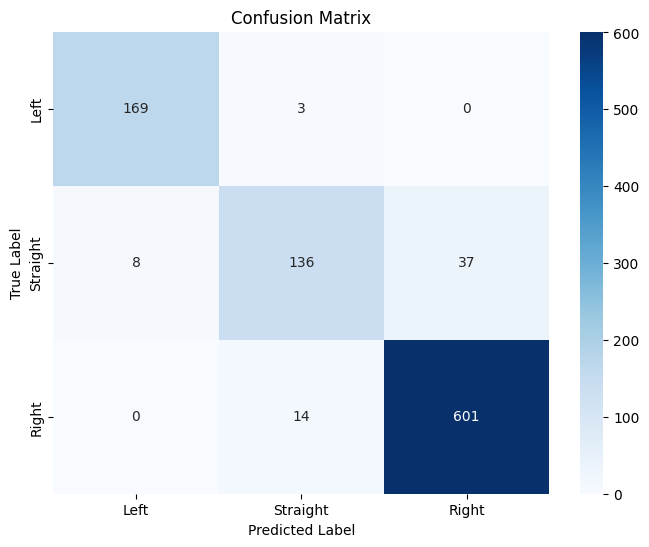

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


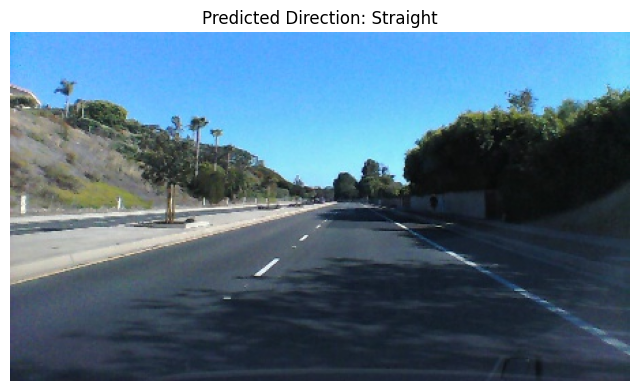

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Load the Dataset
def load_images_and_labels(image_folder, label_file, limit=5000):
    images = []
    labels = []
    with open(label_file, 'r') as file:
        for i, line in enumerate(file):
            if i >= limit:
                break
            parts = line.strip().split()
            image_name = parts[0]
            angle = float(parts[1].split(',')[0])  # Extract angle from format 'angle,date time'
            image_path = os.path.join(image_folder, image_name)
            img = cv2.imread(image_path)
            if img is not None:
                images.append(img)
                labels.append(angle)
            else:
                print(f"Warning: Image {image_path} could not be loaded.")
    return np.array(images), np.array(labels)

# Load images and labels
image_folder = 'F:/data'
label_file = 'F:/data.txt'
images, labels = load_images_and_labels(image_folder, label_file)
print(f"Loaded {len(images)} images and {len(labels)} labels.")

# Step 2: Define preprocessing functions
def preprocess_image(img, target_size=(416, 416)):
    img_resized = cv2.resize(img, target_size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_normalized = img_gray / 255.0
    return img_normalized

# Create a data generator for preprocessing and training
def image_data_generator(images, labels, batch_size=32, target_size=(416, 416)):
    num_samples = len(images)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_images = images[start:end]
            batch_labels = labels[start:end]
            batch_preprocessed_images = np.array([preprocess_image(img, target_size) for img in batch_images])
            batch_preprocessed_images = np.expand_dims(batch_preprocessed_images, axis=-1)  # Add channel dimension
            batch_labels_one_hot = tf.keras.utils.to_categorical(categorize_labels(batch_labels), num_classes=3)
            yield batch_preprocessed_images, batch_labels_one_hot

# Step 3: Build the Lane Detection Models
def build_model1(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    flat = Flatten()(x)
    return input_layer, flat

def build_model2(flat_input):
    x = Dense(128, activation='relu')(flat_input)
    output_layer = Dense(3, activation='softmax')(x)
    return output_layer

input_shape = (416, 416, 1)
input_layer, flat_output = build_model1(input_shape)
final_output = build_model2(flat_output)

# Combine two models into one
combined_model = Model(inputs=input_layer, outputs=final_output)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
combined_model.summary()

# Step 4: Prepare the Data for Training
def categorize_labels(labels):
    categorized_labels = []
    for angle in labels:
        if angle < -1.0:
            categorized_labels.append(0)  # Left
        elif angle > 1.0:
            categorized_labels.append(2)  # Right
        else:
            categorized_labels.append(1)  # Straight
    return np.array(categorized_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
# Create data generators
batch_size = 32  # Adjust batch size as needed
train_generator = image_data_generator(X_train, y_train, batch_size)
val_generator = image_data_generator(X_val, y_val, batch_size)

# Train the model with data generators
history = combined_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

# Step 5: Evaluate the Model
val_steps = len(X_val) // batch_size
val_images = []
val_labels_one_hot = []
# Collect validation images and labels
for _ in range(val_steps):
    batch_images, batch_labels = next(val_generator)
    val_images.append(batch_images)
    val_labels_one_hot.append(batch_labels)
val_images = np.concatenate(val_images)
val_labels_one_hot = np.concatenate(val_labels_one_hot)
val_labels = np.argmax(val_labels_one_hot, axis=1)
# Generate predictions
y_pred_prob = combined_model.predict(val_images)
y_pred = np.argmax(y_pred_prob, axis=1)
# Calculate confusion matrix and classification report
cm = confusion_matrix(val_labels, y_pred)
cr = classification_report(val_labels, y_pred, target_names=['Left', 'Straight', 'Right'])
# Print classification report
print("Classification Report:")
print(cr)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Left', 'Straight', 'Right'], yticklabels=['Left', 'Straight', 'Right'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# Step 6: Predict Lane Departure
def predict_lane_departure(image, model):
    img_preprocessed = preprocess_image(image)
    img_preprocessed = np.expand_dims(img_preprocessed, axis=(0, -1))  # Add batch and channel dimension
    prediction = model.predict(img_preprocessed)
    return np.argmax(prediction)

# Example usage
sample_image = images[0]
direction = predict_lane_departure(sample_image, combined_model)
directions = ['Left', 'Straight', 'Right']

# Display the sample image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(f"Predicted Direction: {directions[direction]}")
plt.axis('off')  # Hide the axis
plt.show()
